## Synthetic data generation with hard regime switching (metabolite-depletion trigger)

For each community (Comm_name) in the input CSV:

1. **Reads observed initial abundances** at the first timepoint (used as the simulation initial condition \(x(0)\)).
2. **Builds a 2-regime gLV model**:
   - Regime 1 uses fixed global parameters \((r_1, A_1)\)
   - Regime 2 uses modified parameters \((r_2, A_2)\) to represent “slower growth”
3. **Defines a hard regime-switching rule** based on an accumulated depletion variable \(A_M(t)\):
   - The simulation runs under Regime 1 until a threshold is reached, then **instantly switches** to Regime 2 and continues.
4. **Simultaneously tracks two integrals** during simulation:
   - Depletion integral \(A_M(t)\)
   - Product integral \(P(t)\)
5. Produces per-community plots:
   - **Plot 1:** abundances vs time (original data vs simulated hard-switch trajectory) with a vertical line marking \(t_{\text{switch}}\)
   - **Plot 2:** depletion \(A_M(t)\) and production \(P(t)\) vs time (dual y-axis) with the same switch marker
6. Exports three CSV files:
   - Simulated abundances for all communities and timepoints
   - Depletion/production timeseries for all communities and timepoints
   - A per-community summary of production outputs based on c_2 * AUC

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.integrate import solve_ivp

# ============================
# Paths / output
# ============================
DATA_PATH = Path("test5sp_v1.csv")

OUT_SIM_ABUND = Path("simulated_abundance_hard_switch.csv")
OUT_DEP_PROD_TS = Path("depletion_production_timeseries.csv")
OUT_PROD_SUMMARY = Path("production_auc_output_summary.csv")

comm_col = "Comm_name"
time_col = "Time"
species_prefix = "sp"

# ============================
# Regime 1 parameters (GLOBAL, fixed)
# ============================
r1 = np.array([0.4, 0.5161, 1.344, 0.797, 1.1601], dtype=float)

A1 = np.array([
    [-1.8809, -0.3182,  0.2710, -0.1583, -0.1612],
    [ 0.0486, -2.3151,  0.5961, -0.3355,  0.5001],
    [ 0.0682,  0.7660, -1.0869, -0.1559,  0.1689],
    [-1.1037,  0.4140,  0.7708, -2.7860,  0.3774],
    [-0.0730,  0.6410,  0.5370,  0.1963, -1.8851],
], dtype=float)

# ============================
# Regime 2 parameters
# ============================
alpha = 0.4
use_same_A = True
strengthen_self_limitation = False
diag_mult = 1.25

# ============================
# Metabolite depletion hard-switch
# trigger: c1 * AM(t) >= M_init
# ============================
c1 = 1.0

# species-specific depletion weights w_i
w = np.array([0.6, 1.4, 0.8, 1.1, 0.9], dtype=float)

# tune gamma so median switch time ~ TARGET_T
TARGET_T = 10.0
GAMMA_SEARCH = True
GAMMA_LO, GAMMA_HI = 1e-3, 1e3
GAMMA_MAX_ITER = 60
GAMMA_TOL = 1e-3

# Guarantee switch for ALL communities
M_INIT_SAFETY = 0.95  # smaller => easier trigger

# ============================
# Production settings (choose 3 producers)
# dP/dt = sum_{i in producers} c2_i * x_i
# output = sum_i c2_i * AUC_i  (AUC over simulated x_i)
# ============================
PRODUCER_SPS = ["sp1", "sp3", "sp5"]       
c2 = np.array([0.9, 0.4, 1.2], dtype=float)  

# ============================
# ODE solver settings
# ============================
atol, rtol = 1e-8, 1e-6

# ============================
# Plot settings
# ============================
FIGSIZE = (13, 4.5)
LINEWIDTH_SIM = 2.8
LINEWIDTH_ORIG = 1.5
MARKERSIZE = 45
ALPHA_ORIG = 0.70
ALPHA_SIM  = 0.95

# ============================
# Load data
# ============================
df = pd.read_csv(DATA_PATH)

species_cols = [c for c in df.columns if c.lower().startswith(species_prefix)]
species_cols = sorted(
    species_cols,
    key=lambda x: int(x[2:]) if x.lower().startswith("sp") and x[2:].isdigit() else x
)

n = len(species_cols)
if n == 0:
    raise ValueError("No species columns found (expected sp1..spN).")
if len(r1) != n or A1.shape != (n, n):
    raise ValueError(f"Dimension mismatch: data has {n} species, but r1/A1 are {len(r1)}/{A1.shape}")
if w.shape[0] != n:
    raise ValueError(f"w must have length {n}.")
if any(sp not in species_cols for sp in PRODUCER_SPS):
    raise ValueError(f"PRODUCER_SPS must be subset of {species_cols}. Got {PRODUCER_SPS}")
if len(PRODUCER_SPS) != len(c2):
    raise ValueError("c2 must have same length as PRODUCER_SPS.")

df[time_col] = pd.to_numeric(df[time_col], errors="coerce")
for c in species_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")
df = df.dropna(subset=[comm_col, time_col] + species_cols).copy()
df = df.sort_values([comm_col, time_col]).reset_index(drop=True)

comms = df[comm_col].astype(str).unique().tolist()
timepoints = np.sort(df[time_col].unique().astype(float))

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_map = {sp: colors[i % len(colors)] for i, sp in enumerate(species_cols)}

# producers index + full-length c2 vector (length n)
producer_idx = np.array([species_cols.index(sp) for sp in PRODUCER_SPS], dtype=int)
c2_full = np.zeros(n, dtype=float)
c2_full[producer_idx] = c2

# Helpers
def glv_dx(x: np.ndarray, r: np.ndarray, A: np.ndarray) -> np.ndarray:
    x = np.maximum(np.nan_to_num(x, nan=0.0), 0.0)
    return x * (r + A.dot(x))

def simulate_regime1_only_AM(x0, t_eval, r, A, w, gamma, atol=1e-8, rtol=1e-6):
    """Regime 1 only, returns AM(t_eval) where dAM/dt = gamma*sum(w_i x_i)."""
    x0 = np.asarray(x0, float)
    y0 = np.concatenate([x0, [0.0]])  # [x..., AM]

    def rhs(t, y):
        x = y[:n]
        dx = glv_dx(x, r, A)
        dAM = float(gamma * np.sum(w * np.maximum(x, 0.0)))
        return np.concatenate([dx, [dAM]])

    sol = solve_ivp(rhs, (float(t_eval[0]), float(t_eval[-1])), y0,
                    t_eval=t_eval, method="RK45", atol=atol, rtol=rtol)
    if not sol.success:
        raise RuntimeError(sol.message)
    return sol.y.T[:, n]

def estimate_switch_time_from_AM(t_eval, AM, c1, M_init):
    trig = c1 * AM
    idx = np.where(trig >= M_init)[0]
    if idx.size == 0:
        return None
    k = int(idx[0])
    if k == 0:
        return float(t_eval[0])
    tL, tR = float(t_eval[k-1]), float(t_eval[k])
    yL, yR = float(trig[k-1]), float(trig[k])
    if yR <= yL:
        return float(tR)
    frac = (M_init - yL) / (yR - yL)
    return float(tL + frac * (tR - tL))

def hard_switch_simulate_on_timepoints_with_AM_P(
    x0: np.ndarray,
    t_eval: np.ndarray,
    r1: np.ndarray, A1: np.ndarray,
    r2: np.ndarray, A2: np.ndarray,
    c1: float, M_init: float,
    w: np.ndarray, gamma: float,
    c2_full: np.ndarray,
    atol=1e-8, rtol=1e-6
):
    """
    Augmented y=[x (n), AM, P]
      dAM/dt = gamma * sum_i w_i x_i
      dP/dt  = sum_i c2_i x_i  (only selected producers have nonzero c2_i)
    Hard switch triggered when c1*AM >= M_init.
    Returns:
      X(t_eval): (T,n)
      t_switch: float or None
      AM(t_eval): (T,)
      P(t_eval): (T,)
    """
    x0 = np.asarray(x0, float)
    t_eval = np.asarray(t_eval, float)
    t0, tf = float(t_eval[0]), float(t_eval[-1])

    # y = [x..., AM, P]
    y0 = np.concatenate([x0, [0.0, 0.0]])

    def rhs_regime(r, A):
        def rhs(t, y):
            x = np.maximum(np.nan_to_num(y[:n], nan=0.0), 0.0)
            dx = glv_dx(x, r, A)
            dAM = float(gamma * np.sum(w * x))
            dP  = float(np.sum(c2_full * x))
            return np.concatenate([dx, [dAM, dP]])
        return rhs

    def event_switch(t, y):
        AM = float(y[n])  # AM index
        return c1 * AM - M_init
    event_switch.terminal = True
    event_switch.direction = 1.0

    # already above threshold at start
    if event_switch(t0, y0) >= 0:
        t_switch = t0
        sol2 = solve_ivp(rhs_regime(r2, A2), (t0, tf), y0, t_eval=t_eval,
                         atol=atol, rtol=rtol, method="RK45")
        if not sol2.success:
            raise RuntimeError(sol2.message)
        Y = sol2.y.T
        X = np.maximum(Y[:, :n], 0.0)
        AM = Y[:, n]
        P  = Y[:, n+1]
        return X, t_switch, AM, P

    # find event time
    sol_event = solve_ivp(rhs_regime(r1, A1), (t0, tf), y0,
                          events=event_switch, atol=atol, rtol=rtol, method="RK45")
    if not sol_event.success:
        raise RuntimeError(sol_event.message)

    if sol_event.t_events[0].size == 0:
        # no switch: evaluate regime1 on t_eval
        sol_all = solve_ivp(rhs_regime(r1, A1), (t0, tf), y0, t_eval=t_eval,
                            atol=atol, rtol=rtol, method="RK45")
        if not sol_all.success:
            raise RuntimeError(sol_all.message)
        Y = sol_all.y.T
        X = np.maximum(Y[:, :n], 0.0)
        AM = Y[:, n]
        P  = Y[:, n+1]
        return X, None, AM, P

    # switch occurred
    t_switch = float(sol_event.t_events[0][0])
    y_switch = sol_event.y_events[0][0].copy()

    tp1 = t_eval[t_eval <= t_switch]
    tp2 = t_eval[t_eval >  t_switch]

    rhs1 = rhs_regime(r1, A1)
    rhs2 = rhs_regime(r2, A2)

    if tp1.size > 0:
        sol1 = solve_ivp(rhs1, (t0, t_switch), y0, t_eval=tp1,
                         atol=atol, rtol=rtol, method="RK45")
        if not sol1.success:
            raise RuntimeError(sol1.message)
        Y1 = sol1.y.T
    else:
        Y1 = np.zeros((0, n+2))

    if tp2.size > 0:
        sol2 = solve_ivp(rhs2, (t_switch, tf), y_switch, t_eval=tp2,
                         atol=atol, rtol=rtol, method="RK45")
        if not sol2.success:
            raise RuntimeError(sol2.message)
        Y2 = sol2.y.T
    else:
        Y2 = np.zeros((0, n+2))

    Y = np.vstack([Y1, Y2])
    X = np.maximum(Y[:, :n], 0.0)
    AM = Y[:, n]
    P  = Y[:, n+1]
    return X, t_switch, AM, P

# Build Regime 2 params
r2 = alpha * r1
A2 = A1.copy() if use_same_A else A1.copy()
if strengthen_self_limitation:
    for i in range(n):
        A2[i, i] = diag_mult * A2[i, i]

# Choose M_init to GUARANTEE all communities can cross by tf

end_vals = []
for comm in comms:
    sub = df[df[comm_col].astype(str) == comm].sort_values(time_col)
    x0 = np.maximum(sub.iloc[0][species_cols].to_numpy(float), 0.0)
    AM1 = simulate_regime1_only_AM(x0, timepoints, r1, A1, w=w, gamma=1.0, atol=atol, rtol=rtol)
    end_vals.append(c1 * float(AM1[-1]))
end_vals = np.asarray(end_vals, float)

min_end = float(np.min(end_vals))
M_init_fixed = float(M_INIT_SAFETY * min_end)
print(f"[M_init_fixed] min_end={min_end:.6g} -> M_init_fixed={M_init_fixed:.6g} (safety={M_INIT_SAFETY})")
print(f"[w] {w}")
print(f"[producers] {PRODUCER_SPS} with c2={c2}")

# Tune gamma so median switch time ~ TARGET_T
def median_switch_time_for_gamma(gamma: float):
    ts = []
    for comm in comms:
        sub = df[df[comm_col].astype(str) == comm].sort_values(time_col)
        x0 = np.maximum(sub.iloc[0][species_cols].to_numpy(float), 0.0)
        AM = simulate_regime1_only_AM(x0, timepoints, r1, A1, w=w, gamma=gamma, atol=atol, rtol=rtol)
        t_sw = estimate_switch_time_from_AM(timepoints, AM, c1=c1, M_init=M_init_fixed)
        if t_sw is not None:
            ts.append(t_sw)
    return None if len(ts) == 0 else float(np.median(ts))

if GAMMA_SEARCH:
    lo, hi = float(GAMMA_LO), float(GAMMA_HI)

    m_lo = median_switch_time_for_gamma(lo)
    m_hi = median_switch_time_for_gamma(hi)

    it = 0
    while m_lo is not None and m_lo < TARGET_T and it < 30:
        lo *= 0.1
        m_lo = median_switch_time_for_gamma(lo)
        it += 1

    it = 0
    while m_hi is not None and m_hi > TARGET_T and it < 30:
        hi *= 10.0
        m_hi = median_switch_time_for_gamma(hi)
        it += 1

    if m_lo is None or m_hi is None:
        gamma_star = 1.0
        print("[gamma tune] fallback gamma=1.0 (couldn't bracket)")
    else:
        for _ in range(GAMMA_MAX_ITER):
            mid = np.sqrt(lo * hi)
            m_mid = median_switch_time_for_gamma(mid)
            if m_mid is None:
                lo = mid
                continue
            if abs(m_mid - TARGET_T) < GAMMA_TOL:
                lo = hi = mid
                break
            # gamma ↑ => faster depletion => earlier switch => median time ↓
            if m_mid > TARGET_T:
                lo = mid
            else:
                hi = mid
        gamma_star = float(np.sqrt(lo * hi))
        print(f"[gamma tune] median switch ~ {median_switch_time_for_gamma(gamma_star):.3f} at gamma={gamma_star:.6g}")
else:
    gamma_star = 1.0


[M_init_fixed] min_end=1.51711 -> M_init_fixed=1.44126 (safety=0.95)
[w] [0.6 1.4 0.8 1.1 0.9]
[producers] ['sp1', 'sp3', 'sp5'] with c2=[0.9 0.4 1.2]
[gamma tune] fallback gamma=1.0 (couldn't bracket)


/var/folders/km/qj7jsjdd029bk_yk066ph4wm0000gn/T/ipykernel_81336/733230078.py:43: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_per_sp = np.trapz(X_sim, x=timepoints, axis=0)  # length n


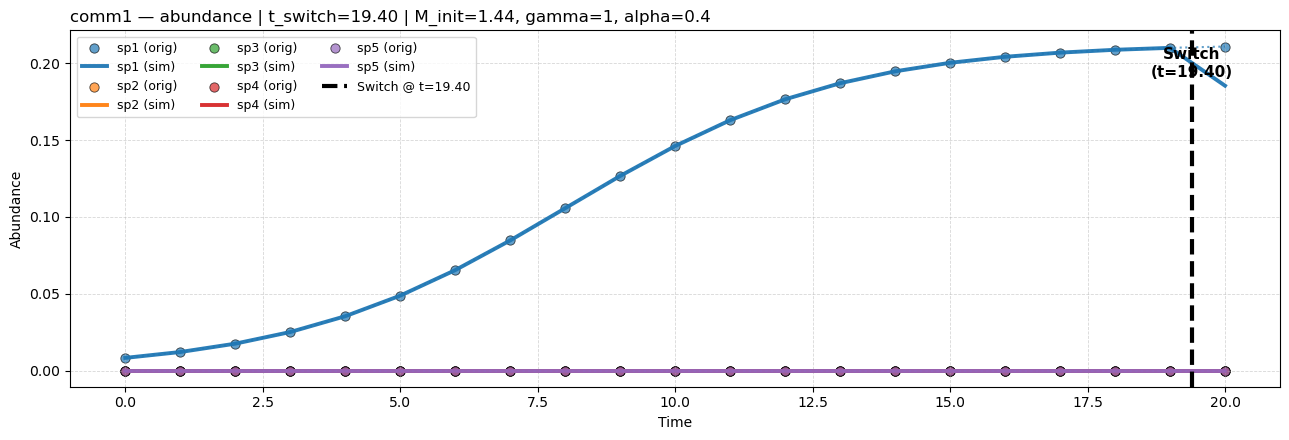

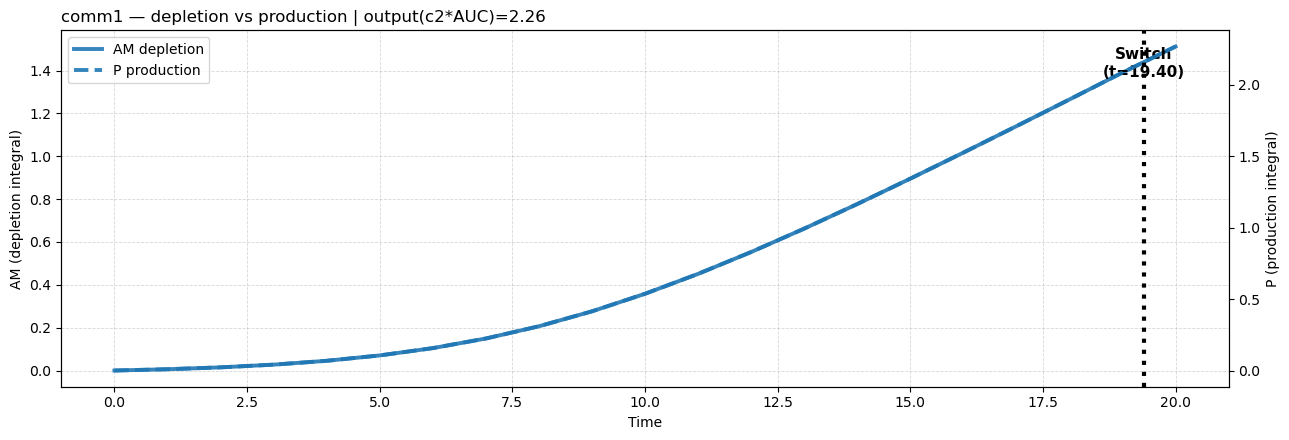

/var/folders/km/qj7jsjdd029bk_yk066ph4wm0000gn/T/ipykernel_81336/733230078.py:43: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_per_sp = np.trapz(X_sim, x=timepoints, axis=0)  # length n


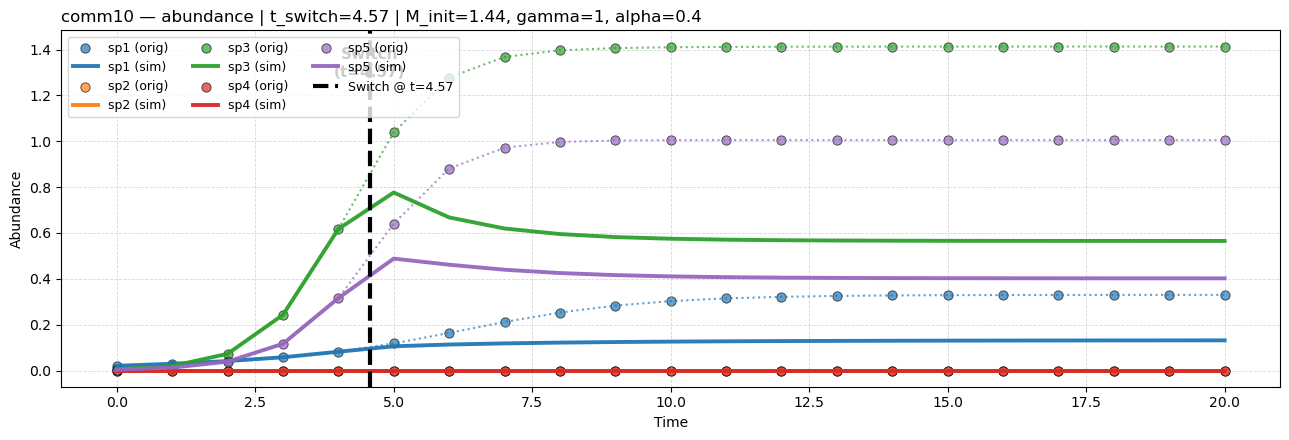

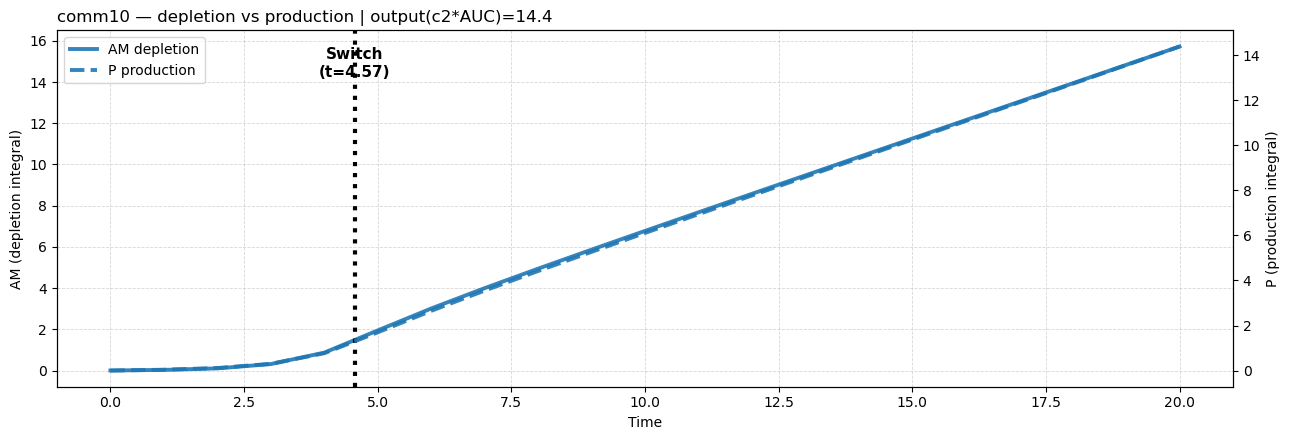

/var/folders/km/qj7jsjdd029bk_yk066ph4wm0000gn/T/ipykernel_81336/733230078.py:43: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_per_sp = np.trapz(X_sim, x=timepoints, axis=0)  # length n


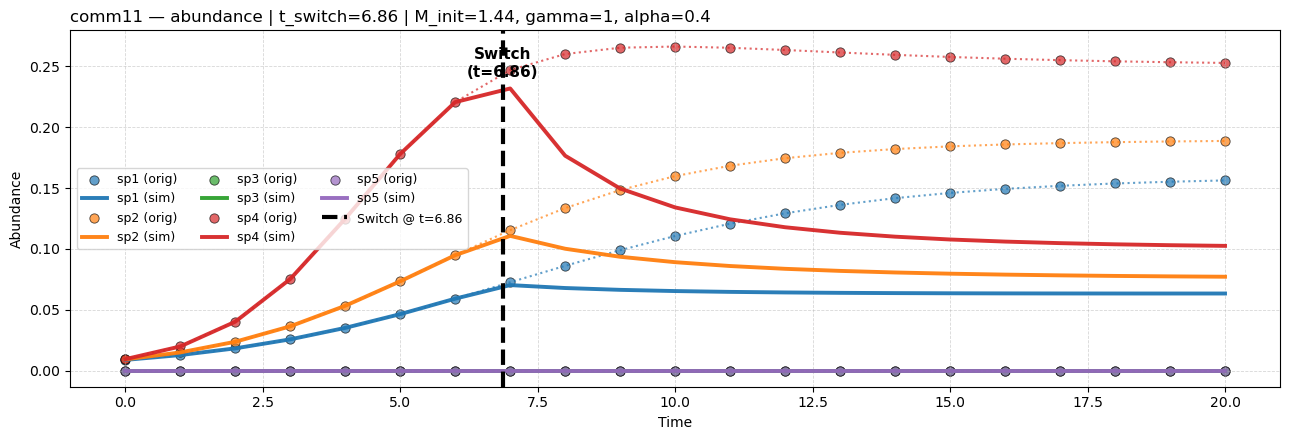

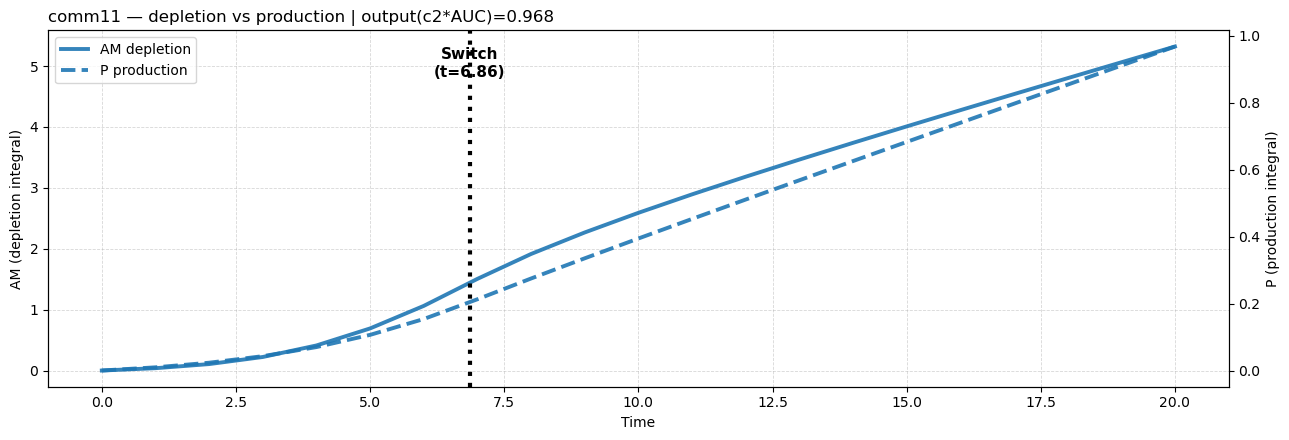

/var/folders/km/qj7jsjdd029bk_yk066ph4wm0000gn/T/ipykernel_81336/733230078.py:43: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_per_sp = np.trapz(X_sim, x=timepoints, axis=0)  # length n


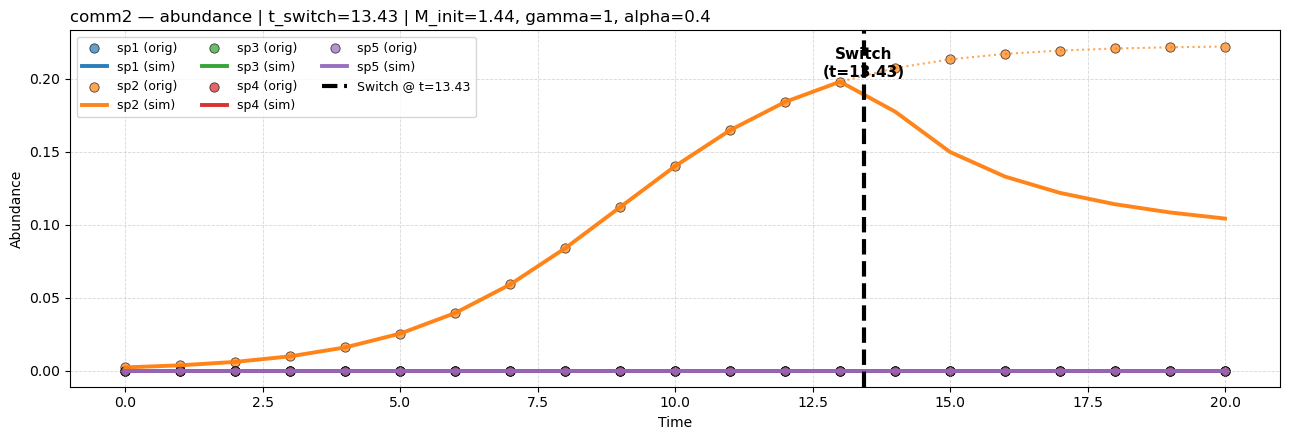

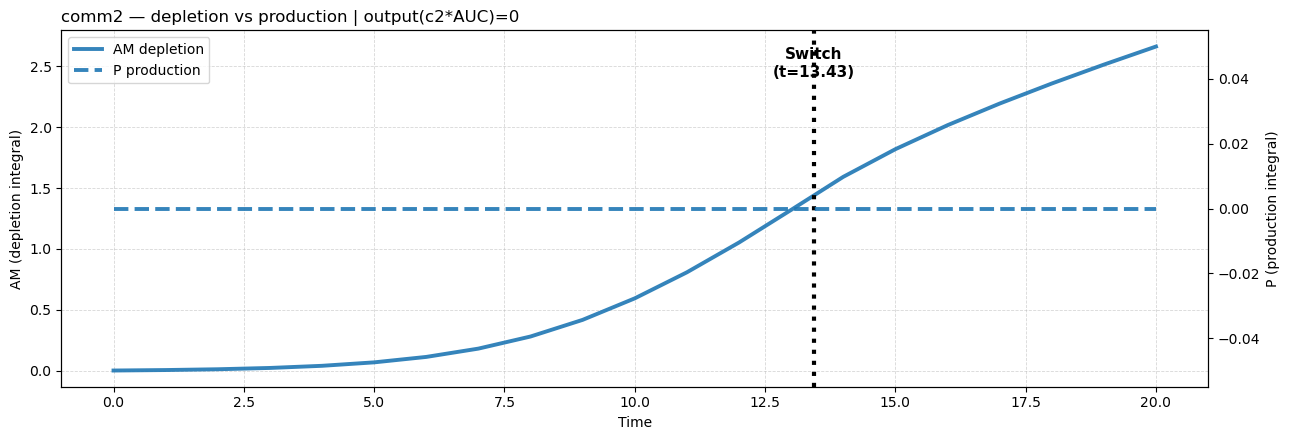

/var/folders/km/qj7jsjdd029bk_yk066ph4wm0000gn/T/ipykernel_81336/733230078.py:43: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_per_sp = np.trapz(X_sim, x=timepoints, axis=0)  # length n


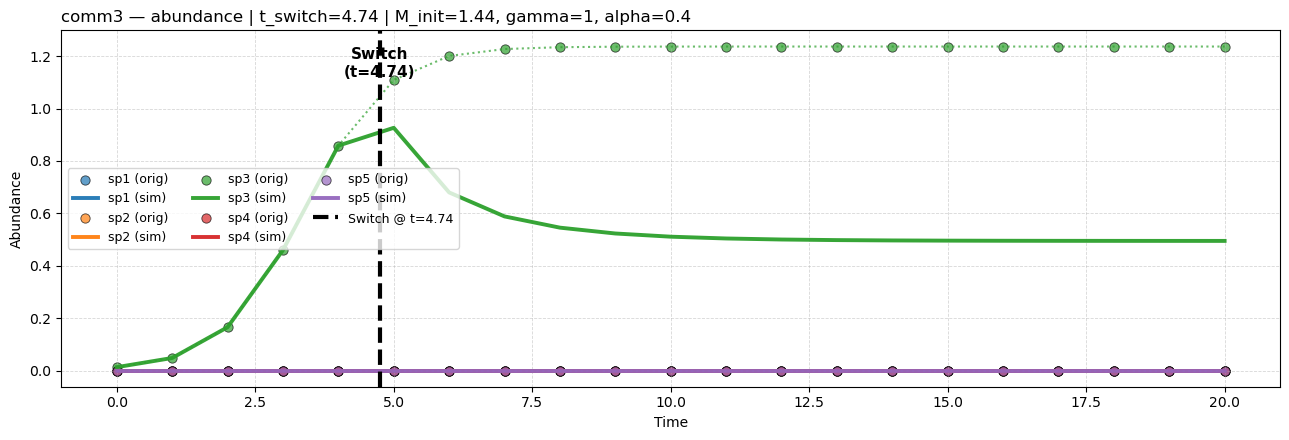

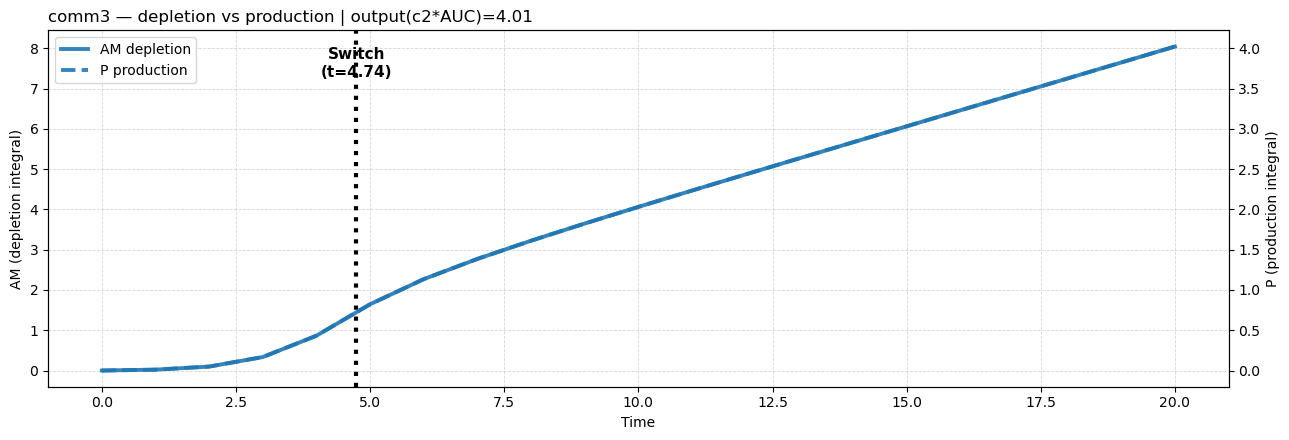

/var/folders/km/qj7jsjdd029bk_yk066ph4wm0000gn/T/ipykernel_81336/733230078.py:43: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_per_sp = np.trapz(X_sim, x=timepoints, axis=0)  # length n


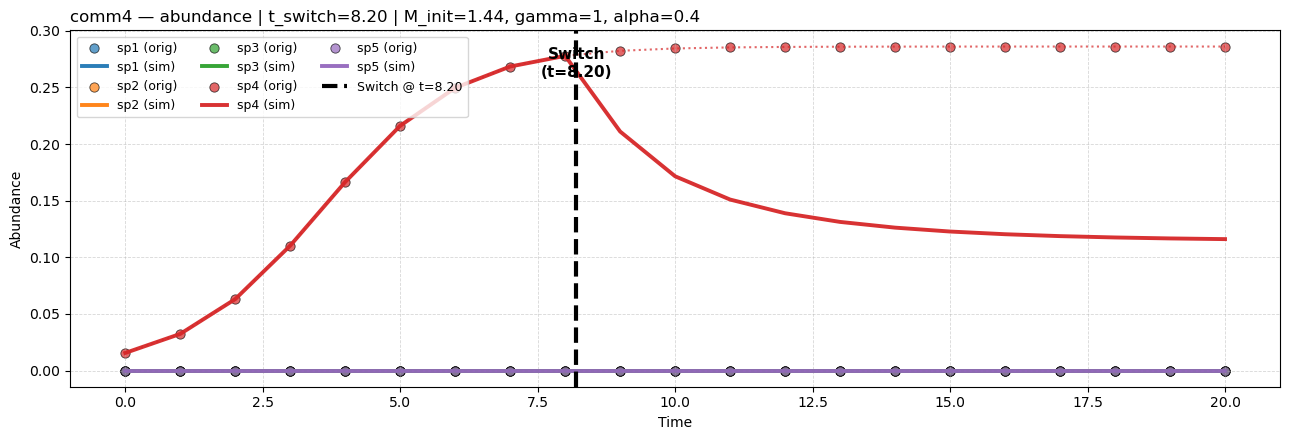

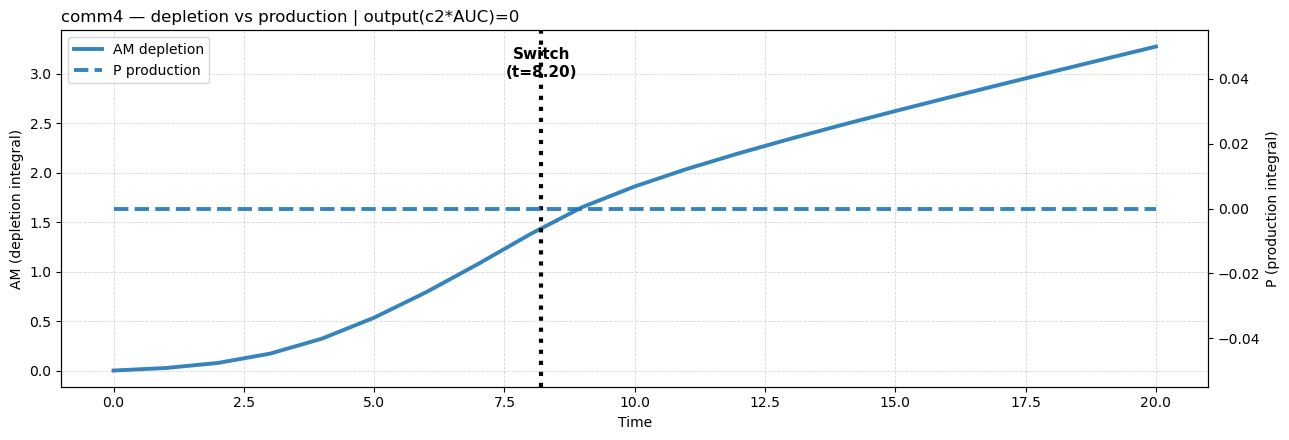

/var/folders/km/qj7jsjdd029bk_yk066ph4wm0000gn/T/ipykernel_81336/733230078.py:43: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_per_sp = np.trapz(X_sim, x=timepoints, axis=0)  # length n


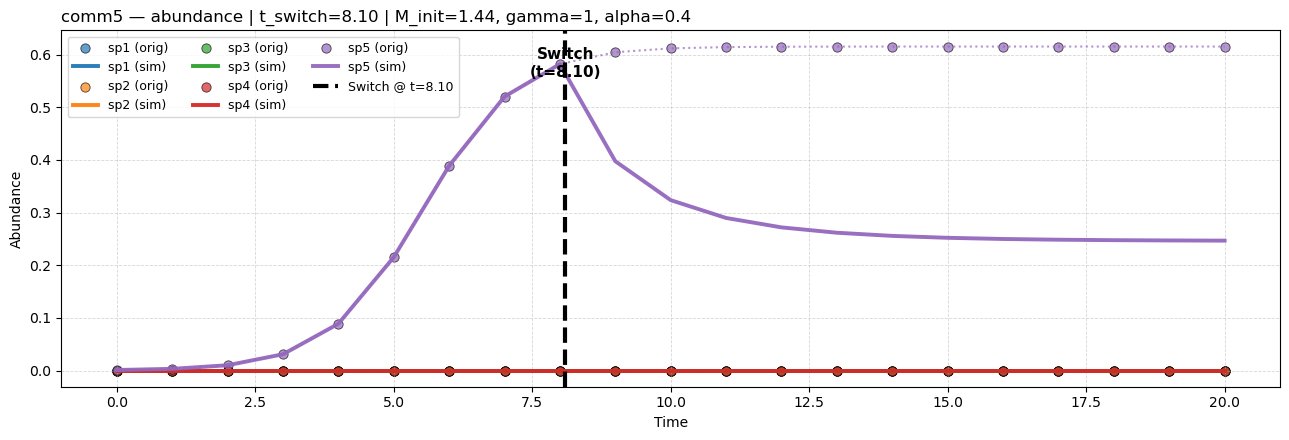

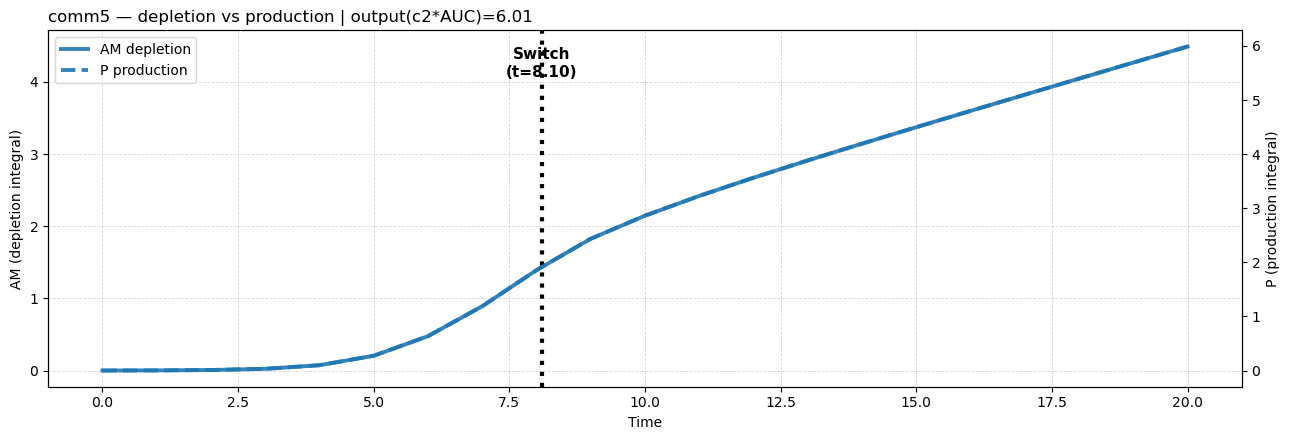

/var/folders/km/qj7jsjdd029bk_yk066ph4wm0000gn/T/ipykernel_81336/733230078.py:43: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_per_sp = np.trapz(X_sim, x=timepoints, axis=0)  # length n


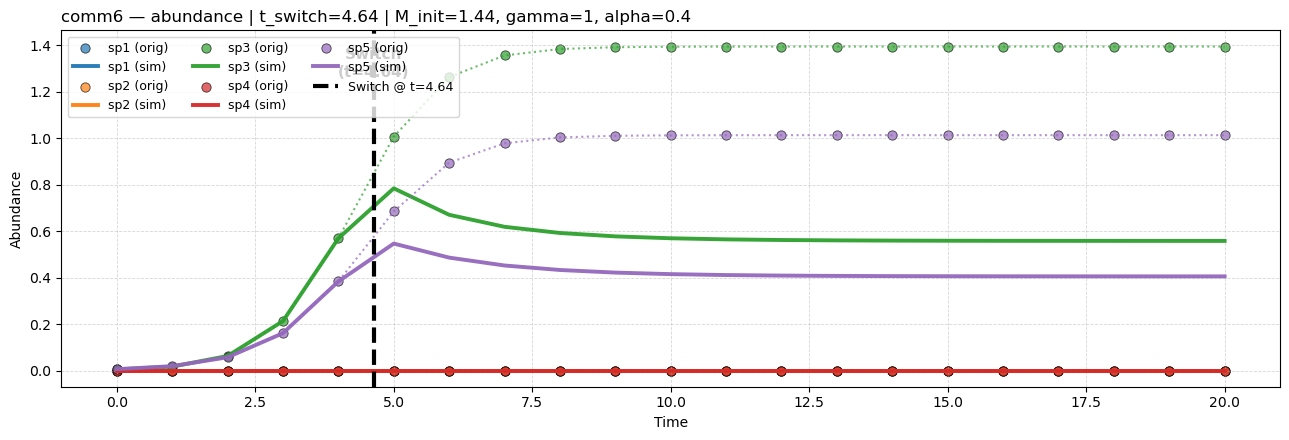

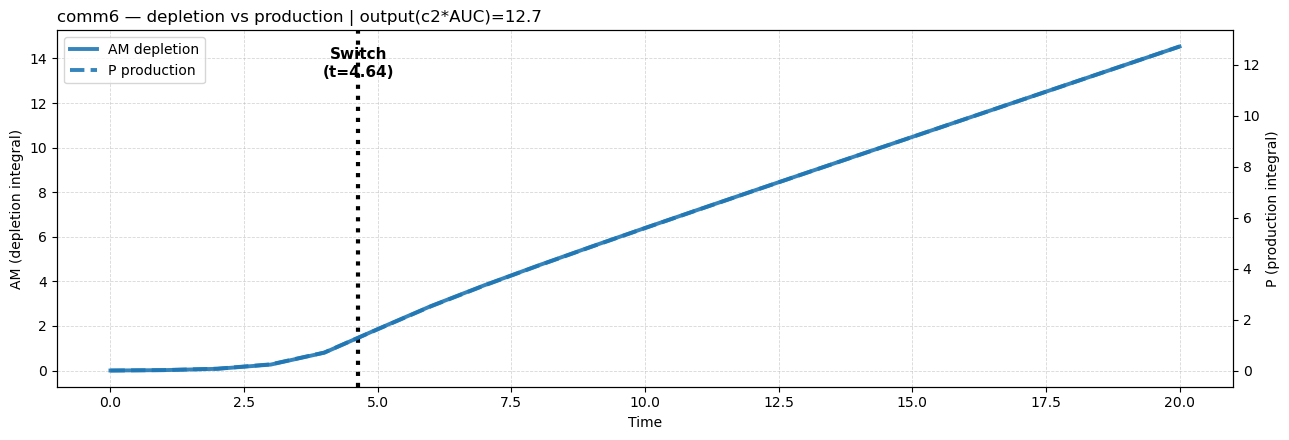

/var/folders/km/qj7jsjdd029bk_yk066ph4wm0000gn/T/ipykernel_81336/733230078.py:43: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_per_sp = np.trapz(X_sim, x=timepoints, axis=0)  # length n


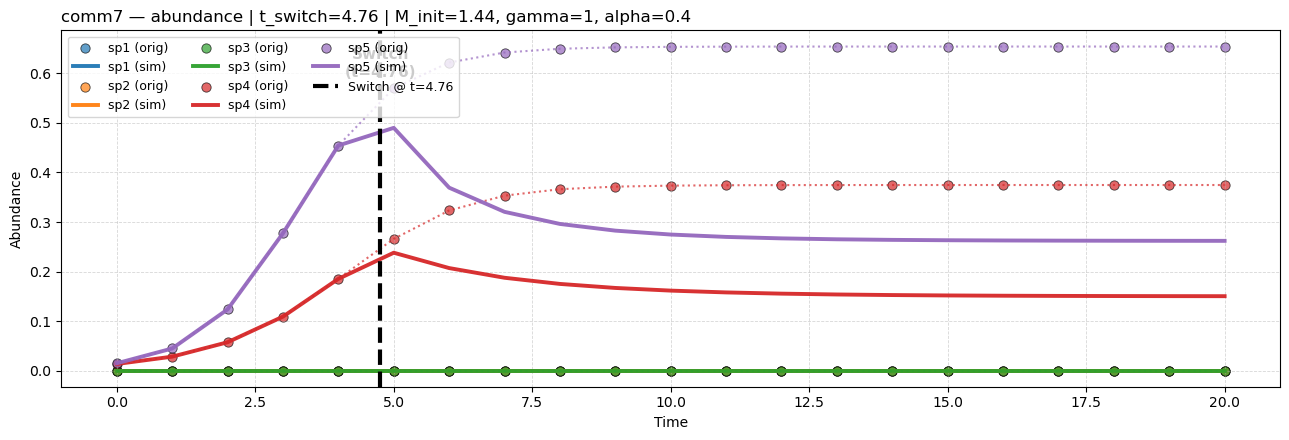

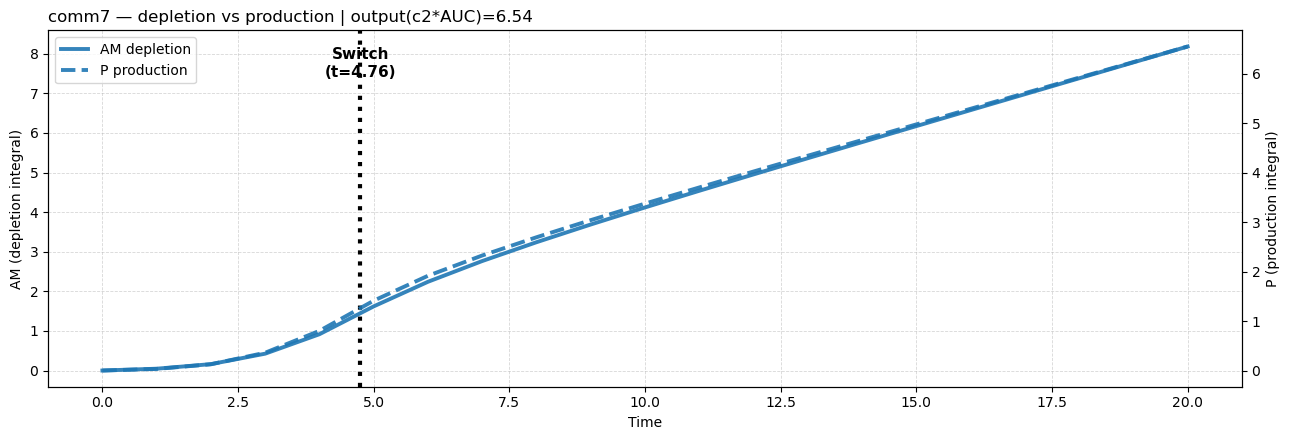

/var/folders/km/qj7jsjdd029bk_yk066ph4wm0000gn/T/ipykernel_81336/733230078.py:43: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_per_sp = np.trapz(X_sim, x=timepoints, axis=0)  # length n


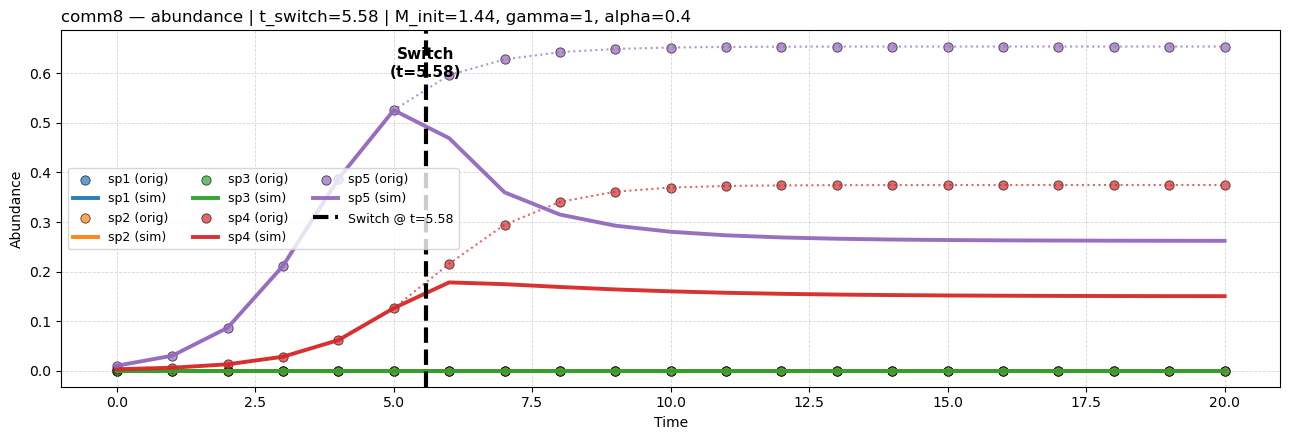

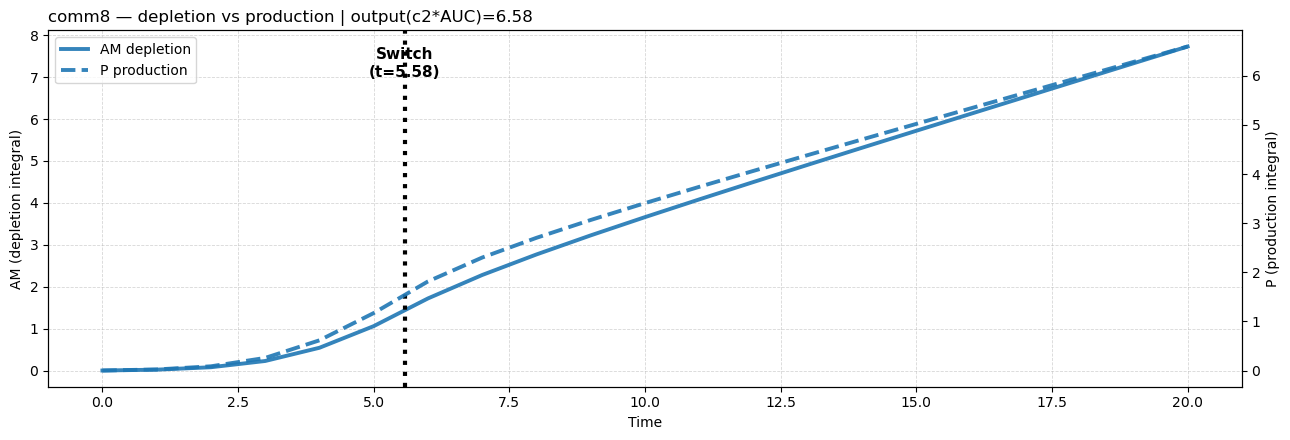

/var/folders/km/qj7jsjdd029bk_yk066ph4wm0000gn/T/ipykernel_81336/733230078.py:43: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_per_sp = np.trapz(X_sim, x=timepoints, axis=0)  # length n


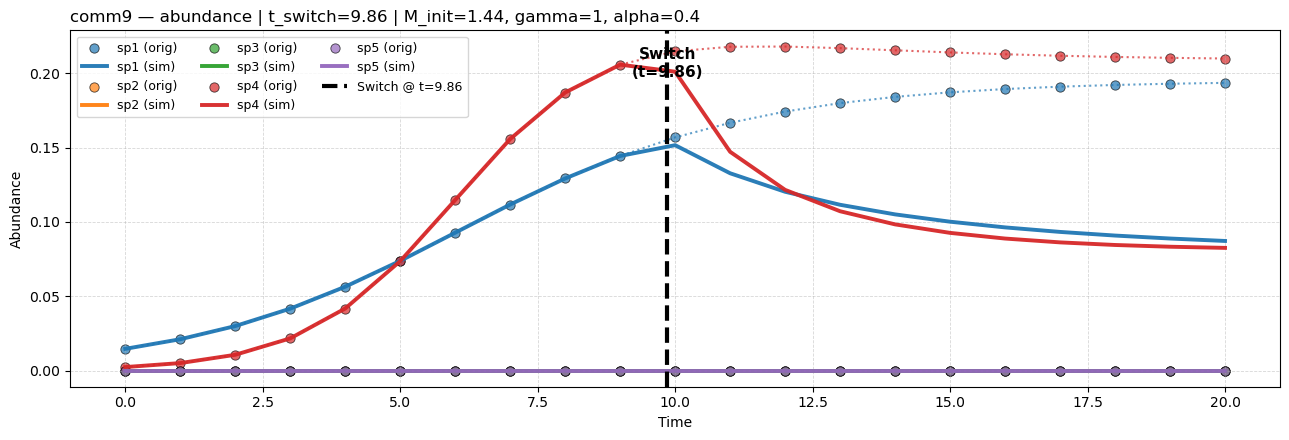

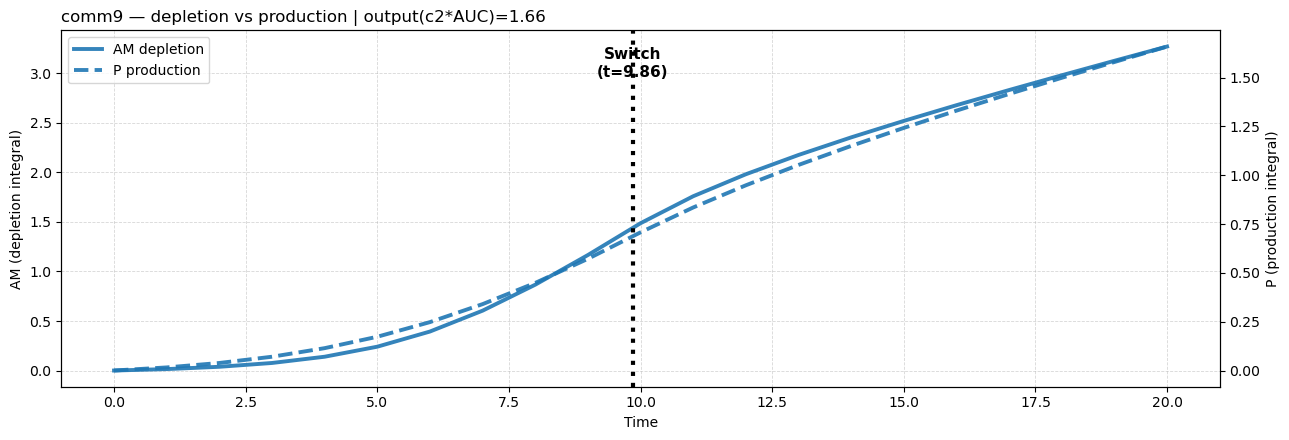


Saved simulated abundance CSV -> /Users/jiayi/Documents/Duke/26Spring/AI for biocomputing/Team project/Test/regime_switch/simulated_abundance_hard_switch.csv
Saved depletion+production timeseries CSV -> /Users/jiayi/Documents/Duke/26Spring/AI for biocomputing/Team project/Test/regime_switch/depletion_production_timeseries.csv
Saved production output summary CSV -> /Users/jiayi/Documents/Duke/26Spring/AI for biocomputing/Team project/Test/regime_switch/production_auc_output_summary.csv

Switch times per community:
Comm_name  t_switch
   comm10  4.565568
    comm6  4.639528
    comm3  4.743111
    comm7  4.756182
    comm8  5.577123
   comm11  6.861497
    comm5  8.095040
    comm4  8.203923
    comm9  9.855585
    comm2 13.431051
    comm1 19.399914


In [2]:
# Run simulation for all communities, plot, and save CSVs
sim_rows = []          # abundance simulation
dep_prod_rows = []     # AM and P timeseries
summary_rows = []      # per-comm outputs

switch_rows = []

for comm in comms:
    sub = df[df[comm_col].astype(str) == comm].sort_values(time_col)
    t_obs = sub[time_col].to_numpy(float)
    X_obs = sub[species_cols].to_numpy(float)
    x0 = np.maximum(X_obs[0].copy(), 0.0)

    X_sim, t_switch, AM_sim, P_sim = hard_switch_simulate_on_timepoints_with_AM_P(
        x0=x0,
        t_eval=timepoints,
        r1=r1, A1=A1,
        r2=r2, A2=A2,
        c1=c1, M_init=M_init_fixed,
        w=w, gamma=gamma_star,
        c2_full=c2_full,
        atol=atol, rtol=rtol
    )

    switch_rows.append((comm, t_switch))

    # ---- Save simulated abundance rows ----
    for ti, t in enumerate(timepoints):
        row = {comm_col: comm, time_col: float(t)}
        for j, sp in enumerate(species_cols):
            row[sp] = float(X_sim[ti, j])
        sim_rows.append(row)

        dep_prod_rows.append({
            comm_col: comm,
            time_col: float(t),
            "AM_depletion": float(AM_sim[ti]),
            "P_production": float(P_sim[ti]),
        })

    # ---- Output = sum_i c2_i * AUC_i (AUC from simulated x) ----
    # AUC per species (trapz)
    auc_per_sp = np.trapz(X_sim, x=timepoints, axis=0)  # length n
    # only producers contribute via c2_full
    output_c2_auc_total = float(np.sum(c2_full * auc_per_sp))
    # producer-wise breakdown
    producer_break = {f"AUC_{sp}": float(auc_per_sp[species_cols.index(sp)]) for sp in PRODUCER_SPS}
    producer_c2auc = {f"c2AUC_{sp}": float(c2_full[species_cols.index(sp)] * auc_per_sp[species_cols.index(sp)])
                      for sp in PRODUCER_SPS}

    summary = {
        comm_col: comm,
        "t_switch": (float(t_switch) if t_switch is not None else np.nan),
        "output_total_c2_auc": output_c2_auc_total,
    }
    summary.update(producer_break)
    summary.update(producer_c2auc)
    summary_rows.append(summary)

    # ============================
    # Plot 1: abundance (orig vs sim)
    # ============================
    fig, ax = plt.subplots(figsize=FIGSIZE)

    for j, sp in enumerate(species_cols):
        col = color_map[sp]

        # original
        ax.plot(t_obs, X_obs[:, j], linestyle=":", linewidth=LINEWIDTH_ORIG,
                color=col, alpha=ALPHA_ORIG)
        ax.scatter(t_obs, X_obs[:, j], s=MARKERSIZE, color=col, edgecolor="black",
                   linewidth=0.6, alpha=ALPHA_ORIG, label=f"{sp} (orig)")

        # simulated
        ax.plot(timepoints, X_sim[:, j], linestyle="-", linewidth=LINEWIDTH_SIM,
                color=col, alpha=ALPHA_SIM, label=f"{sp} (sim)")

    if t_switch is not None:
        ax.axvline(t_switch, linestyle="--", linewidth=3.0, color="black",
                   label=f"Switch @ t={t_switch:.2f}")
        ax.text(t_switch, ax.get_ylim()[1] * 0.95, f"Switch\n(t={t_switch:.2f})",
                ha="center", va="top", fontsize=11, fontweight="bold", color="black")
        sw_txt = f"{t_switch:.2f}"
    else:
        sw_txt = "None"

    ax.set_title(
        f"{comm} — abundance | t_switch={sw_txt} | M_init={M_init_fixed:.3g}, gamma={gamma_star:.3g}, alpha={alpha}",
        loc="left"
    )
    ax.set_xlabel("Time")
    ax.set_ylabel("Abundance")
    ax.grid(True, linestyle="--", linewidth=0.6, alpha=0.5)

    # de-duplicate legend
    handles, labels = ax.get_legend_handles_labels()
    seen = set()
    new_h, new_l = [], []
    for h, l in zip(handles, labels):
        if l not in seen:
            new_h.append(h); new_l.append(l); seen.add(l)
    ax.legend(new_h, new_l, ncol=3, fontsize=9)

    plt.tight_layout()
    plt.show()

    # ============================
    # Plot 2: depletion vs production (AM & P), per community
    # ============================
    fig2, ax1 = plt.subplots(figsize=FIGSIZE)
    ax2 = ax1.twinx()

    # AM on left axis
    ax1.plot(timepoints, AM_sim, linewidth=2.8, linestyle="-", alpha=0.9, label="AM depletion")
    ax1.set_ylabel("AM (depletion integral)")

    # P on right axis
    ax2.plot(timepoints, P_sim, linewidth=2.8, linestyle="--", alpha=0.9, label="P production")
    ax2.set_ylabel("P (production integral)")

    if t_switch is not None:
        ax1.axvline(t_switch, linestyle=":", linewidth=3.0, color="black")
        ax1.text(t_switch, ax1.get_ylim()[1] * 0.95, f"Switch\n(t={t_switch:.2f})",
                 ha="center", va="top", fontsize=11, fontweight="bold", color="black")

    ax1.set_title(
        f"{comm} — depletion vs production | output(c2*AUC)={output_c2_auc_total:.3g}",
        loc="left"
    )
    ax1.set_xlabel("Time")
    ax1.grid(True, linestyle="--", linewidth=0.6, alpha=0.5)

    # combined legend
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1 + h2, l1 + l2, loc="upper left", fontsize=10)

    plt.tight_layout()
    plt.show()

# ============================
# Save CSV outputs
# ============================
df_sim = pd.DataFrame(sim_rows)
df_sim.to_csv(OUT_SIM_ABUND, index=False)

df_dep_prod = pd.DataFrame(dep_prod_rows)
df_dep_prod.to_csv(OUT_DEP_PROD_TS, index=False)

df_summary = pd.DataFrame(summary_rows)
df_summary.to_csv(OUT_PROD_SUMMARY, index=False)

print(f"\nSaved simulated abundance CSV -> {OUT_SIM_ABUND.resolve()}")
print(f"Saved depletion+production timeseries CSV -> {OUT_DEP_PROD_TS.resolve()}")
print(f"Saved production output summary CSV -> {OUT_PROD_SUMMARY.resolve()}")

sw_df = pd.DataFrame(switch_rows, columns=["Comm_name", "t_switch"])
print("\nSwitch times per community:")
print(sw_df.sort_values("t_switch").to_string(index=False))